In [1]:
# all the import statements

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import randint,uniform
from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_validate,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV


In [2]:
def load_data():
    train_data = pd.read_csv('train.csv')
    return train_data
train_data = load_data()

training_data = train_data.drop(columns=["Transported"])
target_data = train_data["Transported"].astype(int)
training_data['Expenses'] = training_data['RoomService'] + training_data['FoodCourt'] + training_data['ShoppingMall'] + training_data['Spa'] + training_data['VRDeck']
training_data['Cabin_firstl'] = training_data['Cabin'].str.extract(r'([A-za-z])',expand=False)
training_data = training_data.drop(columns=["Cabin"])

target_attributes = ["Transported"]
num_attributes = training_data.select_dtypes(include=[np.number]).columns.tolist()
cat_attributes = training_data.select_dtypes(exclude=[np.number]).columns.tolist()
items_to_remove = ["PassengerId", "Name",'CryoSleep','VIP']
new_cat_attributes = [ x for x in cat_attributes if x not in items_to_remove]
bool_attributes = ["CryoSleep", "VIP"]

# scat_matrix = scatter_matrix(training_data,figsize=(10,10),grid=True, diagonal='kde', alpha=0.2)
# training_data.hist(figsize=(10,10), grid=True, bins=20, alpha=0.5)
print("Basic processing completed.")

Basic processing completed.


In [3]:

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean',missing_values=np.nan)),
    ('std_scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('select_k_best', SelectKBest(k=10))  
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

bool_pipeline = Pipeline([  
    ('imputer', SimpleImputer(strategy='most_frequent',missing_values=np.nan)),
    ('int_converter',FunctionTransformer(lambda x : x.astype(int)))])

pre_processing = ColumnTransformer(
    transformers=[
        ('num', num_pipeline,num_attributes),
        ('cat', cat_pipeline,new_cat_attributes),
        ('bool', bool_pipeline,bool_attributes)
    ]
)
print("Pipeline Ready")

Pipeline Ready


In [4]:
def compute_class_weights(train_data):
    class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Transported"]),y=train_data["Transported"])
    class_weight_dict = dict(enumerate(class_weight))
    print("Class weights computed")
    return class_weight_dict
print(target_data)
class_weights = compute_class_weights(train_data)

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64
Class weights computed


In [11]:
sgd_clf = SGDClassifier(random_state=42,loss="hinge",penalty="l2",max_iter=1000, tol=1e-3,
                        alpha=0.00001, learning_rate="optimal", eta0=0.0, power_t=0.5,
                        early_stopping=True,class_weight=class_weights)

svm_clf = SVC(kernel="rbf", C=1.0, gamma='scale', probability=True,random_state=42)

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10,
                                min_samples_split=2, min_samples_leaf=4,
                                max_features=0.3, bootstrap=False,ccp_alpha=0.0,
                                class_weight=class_weights, random_state=42)

model_pipeline = Pipeline([
('pre_processor', pre_processing),
('classifier', rf_clf)])

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cvl_scores = cross_validate(model_pipeline, training_data, target_data, cv=25,scoring=scoring,
                            error_score="raise")
cvl_scores_df = pd.DataFrame(cvl_scores)
print(pd.DataFrame(cvl_scores_df.mean()))   

                             0
fit_time              1.538481
score_time            0.014534
test_accuracy         0.795016
test_precision_macro  0.797780
test_recall_macro     0.794864
test_f1_macro         0.794439


In [6]:

param_dict = {
    'classifier__n_estimators': randint(100,500),
    'classifier__max_depth': randint(0,20),
    'classifier__min_samples_split': randint(2,10),
    'classifier__min_samples_leaf': randint(0,10),
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__ccp_alpha': uniform(0,0.1),
    'classifier__bootstrap': [True, False]
}
# Perform RandomizedSearchCV with SVC-specific parameters
random_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dict, n_iter=10,
                                   scoring='accuracy', cv=10, verbose=1, random_state=42, n_jobs=-1,
                                   error_score='raise')
random_search.fit(training_data, target_data)
print(random_search.best_params_, random_search.best_score_)
print("random_search completed.")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'classifier__bootstrap': False, 'classifier__ccp_alpha': 0.009767211400638388, 'classifier__max_depth': 19, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 363} 0.7648718966178591
random_search completed.


[[0.20676591 0.79323409]
 [0.83577585 0.16422415]
 [0.95740479 0.04259521]
 ...
 [0.19747669 0.80252331]
 [0.96547019 0.03452981]
 [0.01840335 0.98159665]]


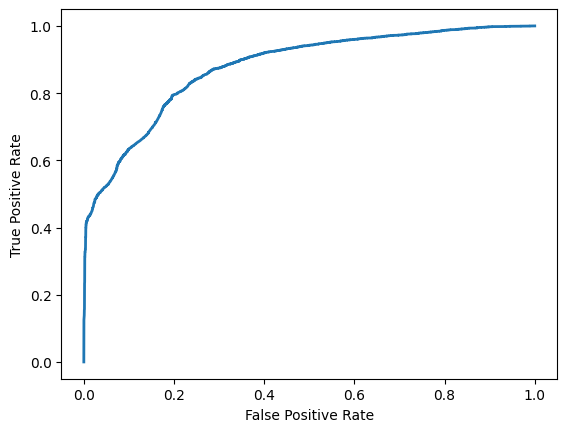

Model training and evaluation completed.


In [7]:
from sklearn.model_selection import cross_val_predict

prd_scores = cross_val_predict(model_pipeline, training_data ,target_data, cv=20,method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(target_data, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")

In [8]:
model_pipeline.fit(training_data, target_data)

test_data = pd.read_csv('test.csv')
test_data['Expenses'] = test_data['RoomService'] + test_data['FoodCourt'] + test_data['ShoppingMall'] + test_data['Spa'] + test_data['VRDeck']
test_data['Cabin_firstl'] = test_data['Cabin'].str.extract(r'([A-za-z])',expand=False)

predict_transporting = model_pipeline.predict(test_data)
predict_surviving = model_pipeline.predict(test_data)
sub_data = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predict_surviving})
sub_data.to_csv('submission.csv', index=False)
print("Submission file created.")

Submission file created.
